# Peak Month of Precipitation and Annual Rainfall Trends in India (2000–2024)

In this notebook, we explore **peak month of precipitation and average annual rainfall** across the Indian Region from 2000 to 2024.

We use **`varunayan`** to extract monthly total precipitation and raw high-resolution precipitation data (latitude-longitude based) from the ERA5 climate reanalysis dataset.

We aim to:
- Identify the **month when rainfall peaks** in each region
- Visualize the **peak rainfall month spatially** across India
- Map the **average annual precipitation intensity** across regions

This study can help identify the peak month of rainfall and its intensity, helpful for agriculture planners and climate enthusiasts.

## Step 1: Extract ERA5 Total Precipitation for India

We use the `varunayan` library to download monthly total precipitation (`tp`) for India from 2000 to 2024 at 0.1° resolution. Unit of precipitation is meters

In [1]:
import varunayan
 
varunayan.era5ify_bbox(
    request_id='rainfall_Indian_region',
    variables=['total_precipitation'],
    start_date='2000-1-1',
    end_date='2024-12-31',
    north=37.1,
    south=6.3,
    east=97.4,
    west=68.1,
    frequency='monthly',
    resolution=0.1
)


STARTING ERA5 SINGLE LEVEL PROCESSING
Request ID: rainfall_Indian_region
Variables: ['total_precipitation']
Date Range: 2000-01-01 to 2024-12-31
Frequency: monthly
Resolution: 0.1°


66c3fdfa3d3be513f9b637537cea8222.zip:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

9bad31012ee0ced1e981a10e7dd70505.zip:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

573eda0df6c6b84fa185d76238e2cbba.zip:   0%|          | 0.00/14.7M [00:00<?, ?B/s]


Saving files to output directory: rainfall_Indian_region_output
  Saved final data to: rainfall_Indian_region_output\rainfall_Indian_region_monthly_data.csv
  Saved unique coordinates to: rainfall_Indian_region_output\rainfall_Indian_region_unique_latlongs.csv
  Saved raw data to: rainfall_Indian_region_output\rainfall_Indian_region_raw_data.csv

PROCESSING COMPLETE

RESULTS SUMMARY:
----------------------------------------
Variables processed: 1
Time period:         2000-01-01 to 2024-12-31
Final output shape:  (300, 3)
Total complete processing time: 325.50 seconds

First 5 rows of aggregated data:
         tp  year  month
0  0.035323  2000      1
1  0.033074  2000      2
2  0.044064  2000      3
3  0.054206  2000      4
4  0.128884  2000      5

ERA5 SINGLE LEVEL PROCESSING COMPLETED SUCCESSFULLY


,tp,year,month
0,0.035323,2000,1
1,0.033074,2000,2
2,0.044064,2000,3
3,0.054206,2000,4
4,0.128884,2000,5
...,...,...,...
295,0.266228,2024,8
296,0.180782,2024,9
297,0.133635,2024,10
298,0.087241,2024,11


## Step 2: Processing Monthly Precipitation Data

We begin by loading the raw monthly precipitation data extracted using `varunayan`. The dataset contains gridded precipitation values (`tp`) for each latitude-longitude point across India.

#### Steps performed:

1. **Monthly Aggregation**

   * Extract the **month** and **number of days** in each entry.
   * Convert `tp` (which is in meters/day) to **total monthly precipitation in millimeters** using:
     `tp × days_in_month × 1000`

2. **Monthly Mean Grid Calculation**

   * Group data by **location and month**, and compute the **mean monthly precipitation** over the years (2000–2024).
   * Pivot the data into a wide format — each row is a location, and each column is a month.

3. **Peak Rainfall Month Detection**

   * For each location, identify the **month with the highest average rainfall**.

4. **Peak Month Precipitation & Total Annual Rainfall**

   * Extract precipitation for the peak month at each location.
   * Calculate the **sum of monthly precipitation values** to estimate **average annual rainfall**.

The resulting dataframe (`result`) contains:

* `latitude`, `longitude`
* `peak_month`: the month when rainfall peaks
* `peak_month_precip`: precipitation during the peak month
* `avg_monsoon_precip`: total average precipitation across all months

This data will be used for spatial visualizations in the next steps.


In [1]:
import pandas as pd

df_raw_prec = pd.read_csv('rainfall_Indian_region_output/rainfall_Indian_region_raw_data.csv')

In [2]:
import numpy as np

df_raw_prec['month'] = pd.to_datetime(df_raw_prec['date']).dt.month
df_raw_prec['date'] = pd.to_datetime(df_raw_prec['date'])
df_raw_prec['days_in_month'] = df_raw_prec['date'].dt.days_in_month

# Convert tp (precipitation in m/day) -> total monthly precipitation (in meters) -> total monthly precipitation (in mm)
df_raw_prec['tp'] = df_raw_prec['tp'] * df_raw_prec['days_in_month'] * 1000


In [3]:
monthly_mean = (
    df_raw_prec.groupby(['latitude', 'longitude', 'month'])['tp']
    .mean()
    .reset_index()
)

In [4]:
pivot_df = monthly_mean.pivot_table(
    index=['latitude', 'longitude'],
    columns='month',
    values='tp'
).reset_index()

In [5]:
pivot_df.columns.name = None

def detect_peak_month(row):
    monthly_vals = row[2:].values 
    return np.argmax(monthly_vals) + 1  

pivot_df['peak_month'] = pivot_df.apply(detect_peak_month, axis=1)

def get_peak_month_precip(row):
    return row[int(row['peak_month'])] 

pivot_df['peak_month_precip'] = pivot_df.apply(get_peak_month_precip, axis=1)

def avg_monsoon_total(row):
    peak = row['peak_month']
    monsoon_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    return row[monsoon_months].sum()

pivot_df['avg_monsoon_precip'] = pivot_df.apply(avg_monsoon_total, axis=1)

result = pivot_df[['latitude', 'longitude', 'peak_month', 'peak_month_precip', 'avg_monsoon_precip']]


In [6]:
pivot_df.to_csv('rainfall_Indian_region_output/aggregated_rainfall_coord_wise.csv', index=False)

In [7]:
result

,latitude,longitude,peak_month,peak_month_precip,avg_monsoon_precip
0,6.3,68.1,5,205.738712,1408.417327
1,6.3,68.2,5,206.832029,1416.722255
2,6.3,68.3,5,207.830631,1422.048801
3,6.3,68.4,5,208.726855,1424.383828
4,6.3,68.5,5,209.740787,1427.170548
...,...,...,...,...,...
90841,37.1,97.0,7,27.636770,114.003676
90842,37.1,97.1,7,29.333958,122.099992
90843,37.1,97.2,7,31.622423,132.460268
90844,37.1,97.3,7,35.038696,148.160758


In [8]:
peak_counts = pivot_df['peak_month'].value_counts(dropna=False).sort_index()

peak_stats = pd.DataFrame({
    'month': peak_counts.index,
    'count': peak_counts.values
})

peak_stats['month'] = peak_stats['month'].apply(lambda x: int(x) if pd.notna(x) else 'NaN')

print(peak_stats)

    month  count
0       2    785
1       3   1091
2       4    770
3       5   2902
4       6  12318
5       7  44032
6       8  14210
7       9   3488
8      10   1493
9      11   8671
10     12   1086


## Step 3: Preparing State Boundaries for Mapping

To overlay accurate **state boundaries** on our precipitation maps, we use a utility script to download and clean a detailed India state GeoJSON.

* We fetch a script (`geojson_splitter.py`) from a GitHub Gist which contains a function to:

  * **Split and clean** multi-geometry GeoJSON files.
  * Ensure geometries are valid and can be plotted reliably.
* The script is executed directly using `exec()`.
* We then call `split_and_clean_states()` on an India state boundary GeoJSON to:

  * Split complex geometries (e.g., MultiPolygons).
  * Save each state as a **clean individual GeoJSON file** for seamless overlay on maps.

These cleaned files will be used to draw precise administrative boundaries when plotting rainfall maps across India.


In [9]:
import requests

gist_url = "https://gist.githubusercontent.com/JaggeryArray/ab0f0ba05a65995702369fa12051ff1d/raw/3847b34e5e9105a11c1613f37dbe8330a6d4d8fa/geojson_splitter.py"

response = requests.get(gist_url)
code = response.text

exec(code)

split_and_clean_states("https://gist.githubusercontent.com/JaggeryArray/fa31964eedb0c2da023c9485772f911a/raw/02c0644de34fbae9dbac2ba0496a00772a2c28cd/india_map_states.geojson", debug_mode=False)


Reading master GeoJSON...
Found 36 features across 36 unique states
Performing initial geometry cleaning...

Processing: A & N Islands
   Cleaning geometries...
   Attempting advanced repair for A & N Islands...
   Saved: split_geojsons\A_N_Islands.geojson (1 features)

Processing: Andhra Pradesh
   Cleaning geometries...
   Saved: split_geojsons\Andhra_Pradesh.geojson (1 features)

Processing: Arunachal Pradesh
   Cleaning geometries...
   Saved: split_geojsons\Arunachal_Pradesh.geojson (1 features)

Processing: Assam
   Cleaning geometries...
   Saved: split_geojsons\Assam.geojson (1 features)

Processing: Bihar
   Cleaning geometries...
   Saved: split_geojsons\Bihar.geojson (1 features)

Processing: Chandigarh
   Cleaning geometries...
   Saved: split_geojsons\Chandigarh.geojson (1 features)

Processing: Chhattisgarh
   Cleaning geometries...
   Saved: split_geojsons\Chhattisgarh.geojson (1 features)

Processing: DNHDD
   Cleaning geometries...
   Saved: split_geojsons\DNHDD.geojso

In [10]:
def setup_matplotlib():
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError(
            "Matplotlib is not installed. Install it with: pip install matplotlib"
        )

    plt.rcParams["figure.dpi"] = 300
    plt.rcParams["savefig.dpi"] = 300
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Arial"]
    plt.rcParams["axes.labelweight"] = "normal"

    plt.rcParams["mathtext.fontset"] = "custom"
    plt.rcParams["mathtext.rm"] = "Arial"
    plt.rcParams["mathtext.it"] = "Arial:italic"
    plt.rcParams["mathtext.bf"] = "Arial:bold"

## Mapping Peak Precipitation Month Across India

We now visualize the **month of peak rainfall** for every coordinate in the dataset.

#### How it works:

* Each location's **peak precipitation month** (1–12) is already computed in the earlier step.
* We assign a **distinct color** to each month using a custom colormap.
* A **scatter plot** of all grid points is created, with color-coded markers representing the peak rainfall month.
* **State boundaries** (from cleaned GeoJSONs) are overlaid for better spatial reference.
* A clear **legend** is added to map colors to month names.

This plot helps reveal the **spatial variation** in monsoon timing — for example, areas where the monsoon arrives early vs. those where it peaks later.

C:\Users\Atharva Jagtap\AppData\Local\Temp\ipykernel_19412\945228509.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['plot_color'] = result.apply(get_color, axis=1)


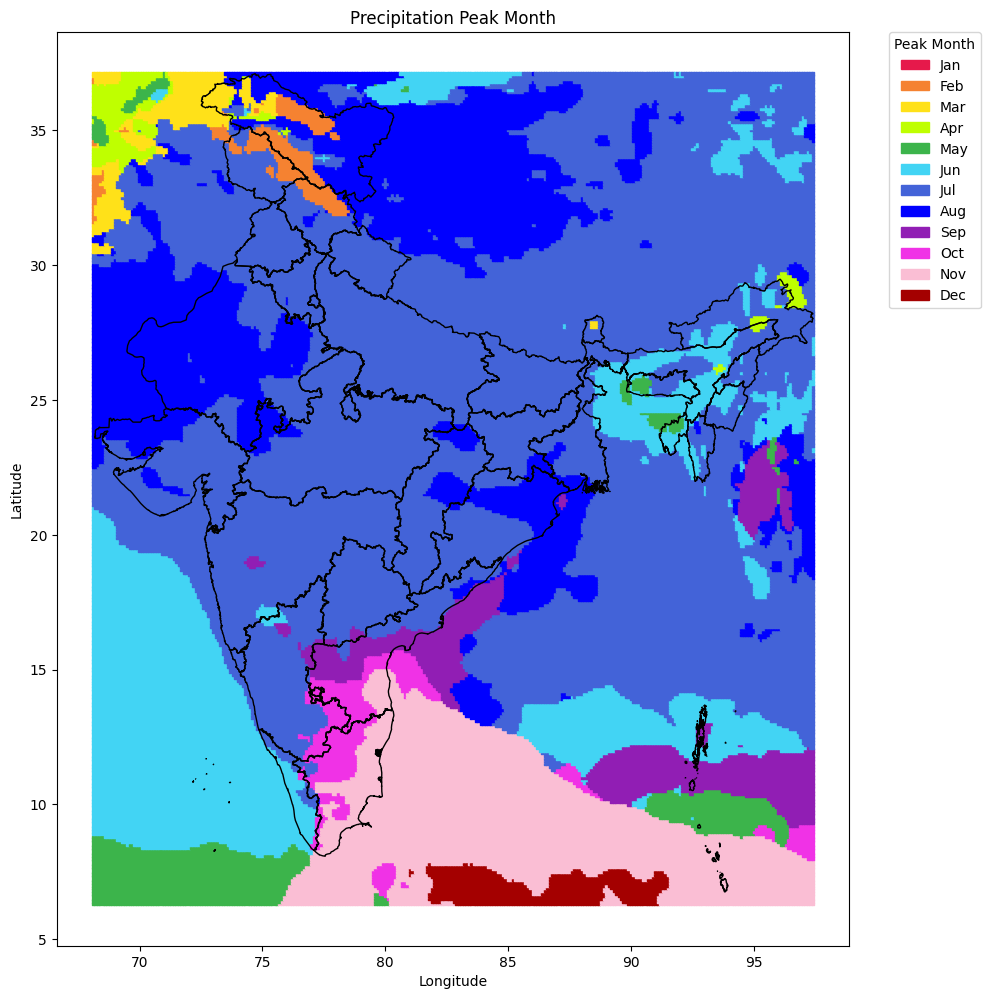

In [11]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import glob
import matplotlib.patches as mpatches
import numpy as np


month_colors = {
    0: (0.901, 0.098, 0.294),   # Jan
    1: (0.961, 0.510, 0.192),   # Feb
    2: (1.000, 0.882, 0.098),   # Mar
    3: (0.749, 1.000, 0.000),   # Apr
    4: (0.235, 0.706, 0.294),   # May
    5: (0.259, 0.831, 0.957),   # Jun
    6: (0.263, 0.388, 0.847),   # Jul
    7: (0.000, 0.000, 1.000),   # Aug
    8: (0.569, 0.118, 0.706),   # Sep
    9: (0.941, 0.196, 0.902),   # Oct
    10: (0.980, 0.745, 0.831),  # Nov
    11: (0.643, 0.000, 0.000),  # Dec
}


def get_color(row):
    base = month_colors[int(row['peak_month']) - 1]  # color for month
    return (base[0], base[1], base[2], 1)

result['plot_color'] = result.apply(get_color, axis=1)

plt.figure(figsize=(10, 12))
plt.scatter(
    result['longitude'], result['latitude'],
    c=result['plot_color'],
    s=3,
    marker='s'
)

# Overlay all state boundaries
for path in glob.glob("split_geojsons/*.geojson"):
    try:
        state_gdf = gpd.read_file(path)
        
        if state_gdf.empty:
            print(f"Skipping {path}: empty file.")
            continue
        
        # Remove invalid geometries
        state_gdf = state_gdf[state_gdf.is_valid & state_gdf.geometry.notnull()]
        
        if state_gdf.empty:
            print(f"Skipping {path}: all geometries invalid or null.")
            continue

        bounds = state_gdf.total_bounds
        if np.any(np.isnan(bounds)) or np.any(np.isinf(bounds)):
            print(f"Skipping {path}: invalid bounds.")
            continue
        
        state_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=1)
        
    except Exception as e:
        print(f"Error reading or plotting {path}: {e}")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Precipitation Peak Month")

# Month names for legend
month_names = {
    0: 'Jan', 1: 'Feb', 2: 'Mar', 3: 'Apr',
    4: 'May', 5: 'Jun', 6: 'Jul', 7: 'Aug',
    8: 'Sep', 9: 'Oct', 10: 'Nov', 11: 'Dec'
}

# Create legend handles
legend_handles = [
    mpatches.Patch(color=month_colors[m], label=month_names[m])
    for m in range(12)
]

# Add legend box (outside plot or inside based on your preference)
plt.legend(
    handles=legend_handles,
    title="Peak Month",
    bbox_to_anchor=(1.05, 1),  # move outside right
    loc='upper left',
    borderaxespad=0.,
    frameon=True
)

plt.tight_layout()
plt.show()

## Mapping Average Annual Monsoon Precipitation 

In this step, we create a **spatial heatmap** of average annual monsoon precipitation across India.

#### How it's done:

* Using the `avg_monsoon_precip` values computed earlier (in mm).
* Creating a scatter plot where each point represents a grid cell and is **color-coded by rainfall intensity**.
* The color scale is based on a **logarithmic normalization**, which helps in better visual contrast across regions with low vs. high rainfall.
* The **`icefire`** colormap from seaborn is used for an intuitive blue-to-red transition.
* We overlay **state boundaries** for better geographic context.

This plot helps reveal the **spatial variation** in annual rainfall.

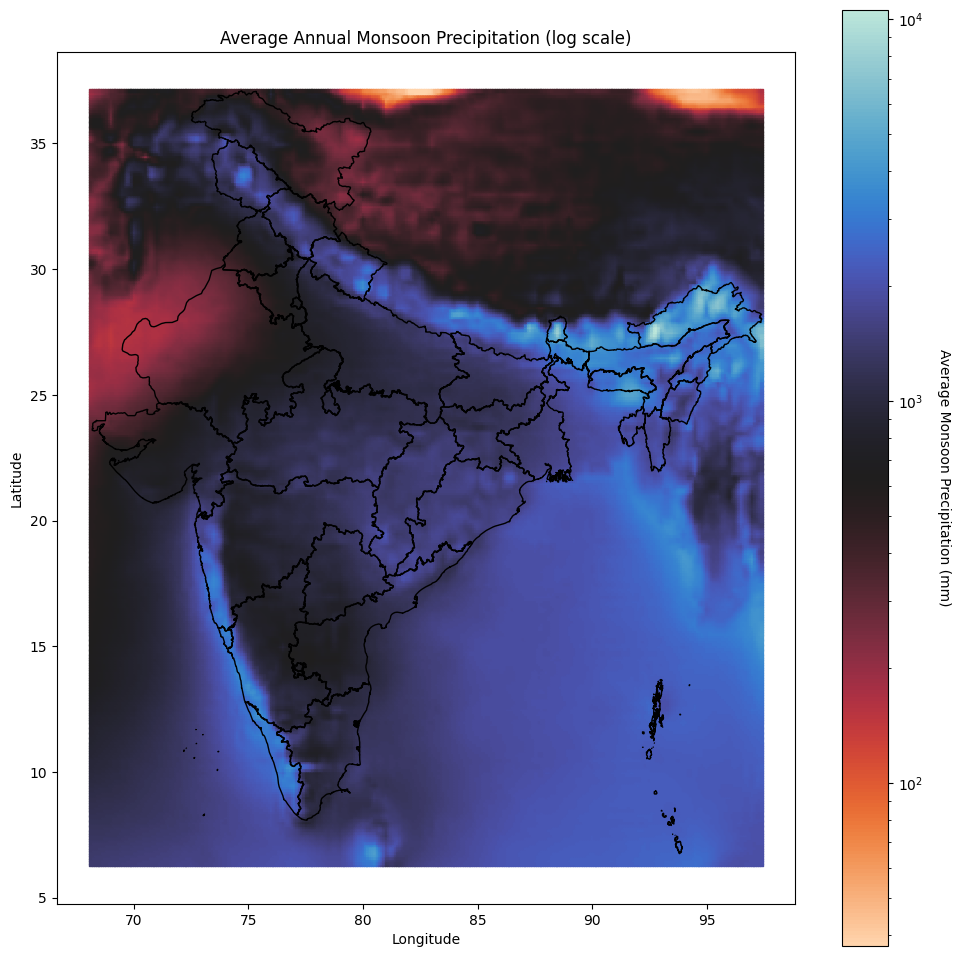

In [14]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import glob
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.colors import Normalize, LogNorm
import matplotlib.cm as cm
import seaborn as sns

plt.figure(figsize=(10, 12))

cmap = 'icefire_r'

min_val = result['avg_monsoon_precip'].min()
max_val = result['avg_monsoon_precip'].max()

if min_val <= 0:
    offset = 0.1
    print(f"Warning: Found values <= 0. Adding offset of {offset}")
    norm = LogNorm(vmin=max(min_val + offset, 0.1), vmax=max_val)
else:
    norm = LogNorm(vmin=min_val, vmax=max_val)

scatter = plt.scatter(
    result['longitude'], result['latitude'],
    c=result['avg_monsoon_precip'],
    cmap=cmap,
    norm=norm,
    s=3,
    marker='s'
)

# Add colorbar
cbar = plt.colorbar(scatter, shrink=0.8)
cbar.set_label('Average Monsoon Precipitation (mm)', rotation=270, labelpad=20)

# Overlay all state boundaries
for path in glob.glob("split_geojsons/*.geojson"):
    try:
        state_gdf = gpd.read_file(path)
        
        if state_gdf.empty:
            print(f"Skipping {path}: empty file.")
            continue
        
        # Remove invalid geometries
        state_gdf = state_gdf[state_gdf.is_valid & state_gdf.geometry.notnull()]
        
        if state_gdf.empty:
            print(f"Skipping {path}: all geometries invalid or null.")
            continue

        bounds = state_gdf.total_bounds
        if np.any(np.isnan(bounds)) or np.any(np.isinf(bounds)):
            print(f"Skipping {path}: invalid bounds.")
            continue
        
        state_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=1)
        
    except Exception as e:
        print(f"Error reading or plotting {path}: {e}")

# Final touches
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Average Annual Monsoon Precipitation (log scale)")

plt.tight_layout()
plt.show()